<a href="https://colab.research.google.com/github/JalalSayed1/AI-Coursework/blob/master/opt_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this assignment, we are going to implement see if we can optimally select a subset of training instances for supervised learning.

In [1]:
pip install -U scikit-learn scipy matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 2.6 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 2.5 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.1
    Uninstalling matplotlib-3.8.1:
      Successfully uninstalled matplotlib-3.8.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

2023-11-20 10:24:14.612980: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-20 10:24:14.636092: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 10:24:14.746498: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 10:24:14.746537: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 10:24:14.747205: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

We are going to work with the MNIST dataset, a popular dataset for hand-written digit recognition. Here we load the datatset.

In [3]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1) # 28x28 pixel images with 1 colour channel (grayscale)

# Load the data and split it between train and test sets
# x = images, y = labels
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255 # 0-255 to 0-1
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1) # -1 means last dimension
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print("Loaded {} train samples".format(x_train.shape[0]))
print("Loaded {} test samples".format(x_test.shape[0]))

x_train shape: (60000, 28, 28, 1)
Loaded 60000 train samples
Loaded 10000 test samples


Now corrupt the labels with common types of mistakes. The variable 'noise_probability' controls the amount of errors introduced.

In [4]:
import random
noise_probability = 0.7

def corrupt_label(y, err):
    found = np.where(err == y)
    if len(found) > 0:
        # select an element at random (index != found)
        noisy_label = random.choice(err)
        while noisy_label == y:
            noisy_label = random.choice(err)
        return noisy_label
    return y

# We corrupt the MNIST data with some common mistakes, such as 3-->8, 8-->3, 1-->{4, 7}, 5-->6 etc.
def corrupt_labels(y_train, noise_probability):
    num_samples = y_train.shape[0]
    err_es_1 = np.array([0, 2, 3, 5, 6, 8, 9])
    err_es_2 = np.array([1, 4, 7])

    corruptions = {}
    corrupted_indexes = {}

    for i in range(num_samples):
        # generate a random number between 0 and 1:
        p = random.random()

        #! if p > noise_probability, then we do not corrupt the label?
        if p < noise_probability:
            y = y_train[i]
            y_noisy = corrupt_label(y, err_es_1)
            if y_noisy == y:
                y_noisy = corrupt_label(y, err_es_2)

            key = str(y_train[i]) + '->' + str(y_noisy)
            corrupted_indexes[i] = i

            if key in corruptions:
                corruptions[key] += 1
            else:
                corruptions[key] = 0

            y_train[i] = y_noisy

    return corruptions, corrupted_indexes

corruptions, corrupted_indexes = corrupt_labels(y_train, noise_probability)
print ("Corruptions: " + str(corruptions))
print ("Corrupted indexes: {}".format(list(corrupted_indexes.keys())[0:10]))


Corruptions: {'0->2': 659, '1->8': 652, '9->8': 717, '3->2': 699, '1->5': 662, '3->9': 749, '5->2': 612, '6->5': 676, '1->6': 660, '7->0': 606, '2->3': 719, '8->6': 658, '6->3': 697, '4->5': 576, '0->6': 691, '1->2': 672, '1->9': 692, '4->8': 564, '2->8': 715, '7->6': 640, '8->2': 678, '6->0': 670, '5->9': 652, '0->3': 698, '7->8': 629, '6->9': 703, '9->6': 680, '9->3': 673, '3->8': 709, '9->5': 677, '4->0': 569, '6->2': 674, '4->9': 556, '5->8': 635, '1->0': 704, '0->8': 671, '7->3': 601, '9->2': 690, '2->0': 702, '3->6': 706, '7->2': 632, '3->0': 707, '5->0': 598, '1->3': 637, '0->5': 686, '2->6': 672, '8->5': 707, '4->2': 610, '8->9': 712, '5->3': 619, '8->0': 671, '9->0': 684, '7->9': 601, '7->5': 649, '5->6': 632, '2->5': 683, '3->5': 681, '8->3': 682, '0->9': 694, '4->3': 609, '6->8': 693, '2->9': 694, '4->6': 593}
Corrupted indexes: [1, 3, 4, 7, 8, 10, 11, 13, 14, 15]


In [5]:
# convert class vectors to binary class matrices
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

Supervised (parametric) training with the (noisy) labeled examples. Note that this model is trained on the entire dataset (the value of the parameter pruned_indexes is null here, which means that we leave out no points), which is noisy (20% of the labels are corrupted). Now the question is: is this the best model that we can train or can we do better?

In [6]:
batch_size = 128
epochs = 3 # very high epochs might overfit the model.
validation_split=0.1


model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

def prune_points(x_train, y_train, pruned_indexes):
    num_samples = x_train.shape[0] # = 60000
    x_train_pruned = []
    y_train_pruned = []
    for i in range(num_samples):
        if not i in pruned_indexes:
            x_train_pruned.append(x_train[i])
            y_train_pruned.append(y_train[i])

    return np.array(x_train_pruned), np.array(y_train_pruned)

def trainAndEvaluateModel(x_train, y_train, x_test, y_test, model, pruned_indexes):

    if not pruned_indexes == None:
        x_train_pruned, y_train_pruned = prune_points(x_train, y_train, pruned_indexes)
    else:
        x_train_pruned = x_train
        y_train_pruned = y_train

    # start training the model:
    model.fit(x_train_pruned, y_train_pruned, batch_size=batch_size, epochs=epochs)
    model.evaluate(x_test, y_test)
    keras.backend.clear_session() # remove previous training weights


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dropout (Dropout)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 10)                54090     
                                                                 
Total params: 54410 (212.54 KB)
Trainable params: 54410 (212.54 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

And we call the following function to train a model on the entire dataset and evaluate it on the test set. The accuracy on the test set is quite good, but can we do better?

In [7]:
trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, None)

Epoch 1/3
469/469 [==============================] - 8s 15ms/step - loss: 1.9944 - accuracy: 0.2448
Epoch 2/3
469/469 [==============================] - 9s 18ms/step - loss: 1.9496 - accuracy: 0.2721
Epoch 3/3
313/313 [==============================] - 1s 1ms/step - loss: 1.3758 - accuracy: 0.8898


You need to implement a subset selection function that when called will return a subset of instances which will be used to train the model. This setup ensures that you also pass in another dictionary which contains the indexes of the instances that you would not want to use while training the model, i.e., it should contain a list of indexes that you would decide to **leave out** for training.

Here's the code and a sample implementation that returns a randomly chosen set of instances that you are to be left out. Since we chose 70% probability of label corruption (check the **noise_probability** parameter), we also select a subset where we leave out the same proportion of points. This is a baseline implementation and obviously you should aim to achieve better results than this.

In [8]:
# Here 'x_train', 'y_train' and model' are an unused parameters. But you may get better results by leveraging these.
def baseLinePrunedSubsetMethod(x_train, y_train, model):
    pruned_indexes = {}
    num_samples = x_train.shape[0]
    for i in range(num_samples):
        p = random.random()

        if p < noise_probability: # this is the global variable (only useful for this naive approach)
            pruned_indexes[i] = i
    return pruned_indexes

Let's see how this naive baseline works.

In [9]:
pruned_indexes = baseLinePrunedSubsetMethod(x_train, y_train, model)
# print (f"pruned_indexes: {pruned_indexes}")
trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, pruned_indexes)

Epoch 1/3
141/141 [==============================] - 2s 14ms/step - loss: 1.9359 - accuracy: 0.2781
Epoch 2/3
141/141 [==============================] - 2s 13ms/step - loss: 1.9265 - accuracy: 0.2807
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 1.4109 - accuracy: 0.8898


Let's now see if we had known what points were actually corrupted (more of a hypothetical unrealistic situation), does leaving out those points actually improve the model's effectiveness. It turns out that it does!

In [10]:

#! This keeps going up and up: bc we keep training the model on the same data. 
trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, corrupted_indexes)

Epoch 1/3
143/143 [==============================] - 2s 12ms/step - loss: 0.3704 - accuracy: 0.9185
Epoch 2/3
143/143 [==============================] - 2s 13ms/step - loss: 0.1829 - accuracy: 0.9486
Epoch 3/3
313/313 [==============================] - 0s 1ms/step - loss: 0.1231 - accuracy: 0.9637


Your task is to implement your own version of (say of name **myPrunedSubsetMethod** (which should take as arguments x_train, y_train, and the model). The function should return a dictionary of indexes that are to be left out. Plug your function in and evaluate the results. Write a thorough report on the methodology and analyse the results.

Some hints:
You can approach this as a discrete state space optimisation problem, where firstly you can define a "selection batch size" (this is not the same as training batch size), which decides which batch of instances you're going to leave out. For instance, if you are in a state where the training set is $X$, you may select (by some heuristics) which points you're gonna leave out (let that set be $\delta \subset X$) so that a child state becomes $X' = X - \delta$. Similarly, if you choose a different $\delta$ you get a different child state. You then need to train and evaluate (call the function *trainAndEvaluateModel*) to see if that child state led to an improvement or not.

You are free to use any algorithm, e.g., simulated annealing, A* search, genetic algorithm etc. to implement this discrete state space optimisation.

<p style="color:red; height:300px"> ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

In [2]:
loss_list = []
acc_list = []
root = {"State": "X", "Accuracy" : 0, "Loss" : 0, "Pruned" : {}, "Next States": []}

#! remove this:
from sklearn.metrics import accuracy_score

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1) # 28x28 pixel images with 1 colour channel (grayscale)

# Load the data and split it between train and test sets
# x = images, y = labels
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255 # 0-255 to 0-1
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1) # -1 means last dimension
x_test = np.expand_dims(x_test, -1)

import random
noise_probability = 0.7

def corrupt_label(y, err):
    found = np.where(err == y)
    if len(found) > 0: #! if y (true label if is in err)
        # select an element at random (index != found)
        noisy_label = random.choice(err)
        while noisy_label == y:
            noisy_label = random.choice(err)
        return noisy_label
    return y #! if y is not in err, then return y (true label) then use error set 2

# We corrupt the MNIST data with some common mistakes, such as 3-->8, 8-->3, 1-->{4, 7}, 5-->6 etc.
def corrupt_labels(y_train, noise_probability):
    num_samples = y_train.shape[0]
    err_es_1 = np.array([0, 2, 3, 5, 6, 8, 9])
    err_es_2 = np.array([1, 4, 7])

    corruptions = {}
    corrupted_indexes = {}

    for i in range(num_samples):
        # generate a random number between 0 and 1:
        p = random.random()

        #! if p > noise_probability, then we do not corrupt the label?
        if p < noise_probability:
            y = y_train[i] # true label
            y_noisy = corrupt_label(y, err_es_1)
            if y_noisy == y:
                y_noisy = corrupt_label(y, err_es_2)

            key = str(y_train[i]) + '->' + str(y_noisy)
            corrupted_indexes[i] = i

            if key in corruptions:
                corruptions[key] += 1
            else:
                corruptions[key] = 0

            y_train[i] = y_noisy

    return corruptions, corrupted_indexes

corruptions, corrupted_indexes = corrupt_labels(y_train, noise_probability)
print ("Corruptions: " + str(corruptions))
print ("Corrupted indexes: {}".format(list(corrupted_indexes.keys())[0:10]))

# convert class vectors to binary class matrices
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)



batch_size = 128
epochs = 3 # very high epochs might overfit the model.
validation_split=0.1


model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

def prune_points(x_train, y_train, pruned_indexes):
    num_samples = x_train.shape[0] # = 60000
    x_train_pruned = []
    y_train_pruned = []
    for i in range(num_samples):
        if not i in pruned_indexes:
            x_train_pruned.append(x_train[i])
            y_train_pruned.append(y_train[i])

    return np.array(x_train_pruned), np.array(y_train_pruned)

def trainAndEvaluateModel(x_train, y_train, x_test, y_test, model, pruned_indexes):

    if not pruned_indexes == None:
        x_train_pruned, y_train_pruned = prune_points(x_train, y_train, pruned_indexes)
    else:
        x_train_pruned = x_train
        y_train_pruned = y_train

    # start training the model:
    model.fit(x_train_pruned, y_train_pruned, batch_size=batch_size, epochs=epochs)
    
    #! remove this:
    y_prob = model.predict(x_test)  # Get predictions
    y_pred = np.argmax(y_prob, axis=1)  # Convert to class labels
    # If y_test is one-hot encoded, convert it back to labels
    y_test_labels = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_test_labels, y_pred)
    print(f"Accuracy: {accuracy}")
    
    #! if my algorithm must use the loss or accuracy, then I can mention in the report:
    loss, accuracy = model.evaluate(x_test, y_test)
    # loss_list.append(loss) #! remove this
    # acc_list.append(accuracy) #! remove this
    #! ------------------------

    keras.backend.clear_session() # remove previous training weights

    #! remove this:    
    return loss, accuracy


Corruptions: {'5->0': 633, '0->5': 682, '4->5': 596, '1->2': 672, '9->5': 652, '2->3': 715, '1->8': 651, '3->8': 702, '4->0': 588, '3->0': 704, '3->6': 705, '6->0': 693, '1->0': 649, '7->9': 608, '2->0': 685, '6->5': 679, '0->3': 753, '9->6': 732, '1->3': 654, '2->8': 696, '4->2': 550, '3->9': 727, '2->5': 674, '7->8': 608, '8->6': 706, '5->9': 622, '7->6': 645, '8->9': 656, '9->0': 708, '9->8': 654, '0->6': 689, '8->2': 669, '4->3': 580, '4->9': 621, '1->9': 712, '0->9': 685, '6->8': 696, '7->3': 611, '9->2': 719, '6->3': 655, '0->8': 692, '4->6': 601, '7->0': 637, '1->5': 658, '3->5': 717, '8->3': 668, '6->9': 719, '2->6': 718, '9->3': 699, '5->2': 609, '1->6': 663, '2->9': 691, '7->2': 656, '8->5': 688, '6->2': 706, '5->3': 602, '7->5': 619, '5->8': 613, '0->2': 668, '4->8': 595, '3->2': 729, '5->6': 659, '8->0': 736}
Corrupted indexes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                

In [14]:

#! moved out to archive

In [3]:
def get_random_index(y_train, risk_labels):
    # Find indices of all elements in y_train that match any of the risk labels
    risk_indices = np.where(np.isin(y_train, risk_labels))[0]

    # If there are no matching indices, return None or handle as needed
    if len(risk_indices) == 0:
        return None

    # Randomly select an index from the risk indices
    return np.random.choice(risk_indices, size=1, replace=False)[0]

def heuristic_to_identify_samples(x_train, y_train, num_samples_to_remove):
    #! ASSUMPTION: might have to have num_samples_to_remove be less than len(y_train or x_train) for this to work
    high_risk_labels = [0, 2, 3, 5, 6, 8, 9]
    medium_risk_labels = [1, 4, 7]

    # sample_risks = []

    # for index, label in enumerate(y_train):
    #     if label in high_risk_labels:
    #         risk = 0.6  # 60% chance of being mislabeled
    #     elif label in medium_risk_labels:
    #         risk = 0.23  # 23% chance

    #     sample_risks.append((index, risk))

    # Sort samples by descending risk (higher risk first)
    # sorted_samples = sorted(sample_risks, key=lambda x: x[1], reverse=True)

    # Select top 'num_samples_to_remove' indexes
    # indexes_to_remove = [index for index, risk in sorted_samples[:num_samples_to_remove]]

    num_of_high_risk = int(num_samples_to_remove * 0.6)
    num_of_medium_risk = int(num_samples_to_remove * 0.23)
    possible_num_of_index_to_remove = num_of_high_risk + num_of_medium_risk
    
    # a set of indexes to remove:
    indexes_to_remove = set()
    
    
    #! risk this loop doesn't terminate bc we might not have enough samples to remove:
    # num_of_high_risk > 0 and
    # while len(indexes_to_remove) < num_samples_to_remove and (num_of_high_risk > 0 or num_of_medium_risk > 0):
    # while len(indexes_to_remove) < possible_num_of_index_to_remove:
    print(f"len(indexes_to_remove): {len(indexes_to_remove)}")
    # index = np.random.choice(np.where(y_train == random.choice(high_risk_labels))[0], size=1, replace=False)
    # get num_of_high_risk indexes from data:
    while num_of_high_risk > 0 and len(indexes_to_remove) < possible_num_of_index_to_remove:
        #! check if index is None:
        #! ASSUMPTION: if there is no enough elements, get_random_index might return the same index over and over again. preventing the loop from terminating:
        index = get_random_index(y_train, high_risk_labels)
        if not index in indexes_to_remove:
            indexes_to_remove.add(index)
            num_of_high_risk -= 1
            
    print(f"len(indexes_to_remove) 2: {len(indexes_to_remove)}")
    while num_of_medium_risk > 0 and len(indexes_to_remove) < possible_num_of_index_to_remove:
        #! check if index is None:
        index = get_random_index(y_train, medium_risk_labels)
        if not index in indexes_to_remove:
            indexes_to_remove.add(index)
            num_of_medium_risk -= 1
        
        
        # if not index in indexes_to_remove:
        #     indexes_to_remove.extend(index)
        #     num_of_high_risk -= 1
            
    # while num_of_medium_risk > 0 and len(indexes_to_remove) < num_samples_to_remove:
    #     index = np.random.choice(np.where(y_train == random.choice(medium_risk_labels))[0], size=1, replace=False)
    #     if not index in indexes_to_remove:
    #         indexes_to_remove.extend(index)
    #         num_of_medium_risk -= 1

    return indexes_to_remove


import numpy as np
import random

def test_heuristic_to_identify_samples():
    # Create a mock dataset
    y_train_mock = np.array([0, 2, 3, 1, 4, 7, 5, 6, 8, 9, 0, 2])  # Example labels
    num_samples_to_remove = len(y_train_mock)-2  # Example number of samples to remove

    # Expected outcome
    expected_high_risk_labels = [0, 2, 3, 5, 6, 8, 9]
    expected_indexes = []

    for i, label in enumerate(y_train_mock):
        if label in expected_high_risk_labels:
            expected_indexes.append(i)
            if len(expected_indexes) == num_samples_to_remove:
                break

    # Call the function
    actual_indexes = heuristic_to_identify_samples(None, y_train_mock, num_samples_to_remove)
    print(f"{len(actual_indexes)} != {num_samples_to_remove}")
    # Assert the results
    # assert len(actual_indexes) == num_samples_to_remove, "Incorrect number of samples removed"
    # assert all([index in expected_indexes for index in actual_indexes]), "Incorrect indexes identified for removal"

def divide_into_even_subsets(array, subset_percentage=10):
    #! refactor this:
    """
    Divides an array into smaller subsets, each approximately of a specified percentage size of the original array.
    The function evenly distributes any extra elements among the subsets.
    
    :param array: The original NumPy array to divide.
    :param subset_percentage: The size of each subset as a percentage of the original array.
    :return: A list of NumPy arrays, each being a subset of the original array.
    """
    total_size = len(array)
    subset_base_size = total_size * subset_percentage // 100
    extra_elements = total_size - (subset_base_size * 10)
    
    subsets = []
    start_index = 0

    for i in range(10):
        end_index = start_index + subset_base_size + (1 if i < extra_elements else 0)
        subsets.append(array[start_index:end_index])
        start_index = end_index

    return subsets

def find_most_representative_subset(subsets, full_data):
    """
    Finds the subset that is most representative of the full dataset based on mean and standard deviation.
    
    :param subsets: A list of NumPy arrays (subsets).
    :param full_data: The original full dataset as a NumPy array.
    :return: The index of the most representative subset.
    """
    full_mean = np.mean(full_data)
    full_std = np.std(full_data)

    closest_mean_index = None
    closest_mean_diff = float('inf')

    for i, subset in enumerate(subsets):
        subset_mean = np.mean(subset)
        subset_std = np.std(subset)

        mean_diff = abs(subset_mean - full_mean)
        std_diff = abs(subset_std - full_std)

        # Combine the differences in mean and standard deviation
        total_diff = mean_diff + std_diff

        if total_diff < closest_mean_diff:
            closest_mean_diff = total_diff
            closest_mean_index = i

    return closest_mean_index

# initially the pruned dataset is the entire dataset:
x_train_pruned, y_train_pruned = x_train, y_train
highest_accuracy = 0
depth = 0

In [4]:
import matplotlib.pyplot as plt

def myPrunedSubsetMethod(x_train, y_train, model):
    
    pruned_indexes = {} # to be returned
    temp_pruned_indexes_1 = {}
    temp_pruned_indexes_2 = {}
    counter = 0 # for naming the nodes (first will 1 as 0 is technically the root)
    
    divide_factor = 10 # %
    x_subsets = divide_into_even_subsets(x_train, subset_percentage=divide_factor)
    y_subsets = divide_into_even_subsets(y_train, subset_percentage=divide_factor)
    
    most_representative_x_subset_index = find_most_representative_subset(x_subsets, x_train)
    most_representative_y_subset_index = find_most_representative_subset(y_subsets, y_train)
    
    # validation_x_set = x_subsets[most_representative_x_subset_index]
    # validation_y_set = y_subsets[most_representative_x_subset_index]
    # all the other subsets are training sets:
    # training_x_set = np.concatenate([x for i, x in enumerate(x_subsets) if i != most_representative_x_subset_index])
    # training_y_set = np.concatenate([y for i, y in enumerate(y_subsets) if i != most_representative_y_subset_index])
    
    # loss, accuracy = trainAndEvaluateModel(training_x_set, training_y_set, validation_x_set, validation_y_set, model, None)
    
    
    
    # to get incremented as training progresses to find optimal number of samples to remove:
    min_num_samples_to_remove = 1
    
myPrunedSubsetMethod(x_train, y_train, model)

: 

In [ ]:
# def myPrunedSubsetMethod(x_train, y_train, model):

#     pruned_indexes = {} # to be returned
#     temp_pruned_indexes_1 = {}
#     temp_pruned_indexes_2 = {}
#     counter = 0 # for naming the nodes (first will 1 as 0 is technically the root)
    
#     # global x_train_pruned
#     # global y_train_pruned
    
#     # to get incremented as training progresses to find optimal number of samples to remove:
#     min_num_samples_to_remove = 1





#     base_loss, base_accuracy = trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, None)
#     highest_accuracy = base_accuracy  
    

#     indexes_to_remove = heuristic_to_identify_samples(x_train, y_train, min_num_samples_to_remove)
    
#     x_train_pruned = np.delete(x_train, indexes_to_remove, axis=0)
#     y_train_pruned = np.delete(y_train, indexes_to_remove, axis=0)

#     # 1. train the model on the entire dataset. (start state)
#     # 2. get the predictions.
#     base_loss, base_accuracy = trainAndEvaluateModel(x_train_pruned, y_train_onehot, x_test, y_test_onehot, model, None)
    
#     highest_accuracy = base_accuracy
#     # 3. improved accuracy (accuracy - base_accuracy) is the reward function (what is the utility?). Make the state diagram:
#     update_accuracy_loss(root, base_accuracy, base_loss) # nothing is pruned at the start state
    
    
    
    #! think about how to do this: I'm not making a graph anymore
    
    

    # 4. retrain the model without a subset of the data (next state, first child of start state).
    # remove 1% of the data:
    # num_samples = x_train_pruned.shape[0]
    
    # # remove_percentage = 0.001
    # # depth = 0
    
    # try:
    #     while highest_accuracy < 0.90 and depth < 10:
            
    #         print(f"\nRunning iteration {depth}")
            
    #         counter, accuracy_1, temp_pruned_indexes_1 = retrain_model(x_train_pruned, y_train_pruned, num_samples, counter)
            
    #         # 6. keep track of the highest accuracy. if we get >95% then stop.
    #         if accuracy_1 > highest_accuracy:
    #             print ("Accuracy improved!")
    #             highest_accuracy = accuracy_1
    #             if accuracy_1 > 0.95:
    #                 break
                

    #         # 5. retrain the model without another subset of the data (next state, second child of start state).
    #         counter, accuracy_2, temp_pruned_indexes_2 = retrain_model(x_train_pruned, y_train_pruned, num_samples, counter)

    #         # 6. keep track of the highest accuracy. if we get >95% then stop.
    #         if accuracy_2 > highest_accuracy:
    #             print ("Accuracy improved!")
    #             highest_accuracy = accuracy_2
    #             if accuracy_2 > 0.95:
    #                 break
            
    #         # 7. compare the two accuracies. keep the one with the highest accuracy. (next state, first child of first child of start state).
    #         if accuracy_1 > accuracy_2:
    #             print(f"Accuracy 1: {accuracy_1} > Accuracy 2: {accuracy_2}")
    #             x_train_pruned, y_train_pruned = prune_points(x_train_pruned, y_train_pruned, temp_pruned_indexes_1)
    #             pruned_indexes = temp_pruned_indexes_1
    #         else:
    #             print(f"Accuracy 2: {accuracy_2} > Accuracy 1: {accuracy_1}")
    #             x_train_pruned, y_train_pruned = prune_points(x_train_pruned, y_train_pruned, temp_pruned_indexes_2)
    #             pruned_indexes = temp_pruned_indexes_2
                
    # except KeyboardInterrupt as e:
    #     print(e)
    #     return pruned_indexes
        
    # else:
    #     depth += 1
    #     return pruned_indexes
    
    # 7. keep doing so until d depth or highest accuracy achieved? making a binary search tree.

    # 8. use a search algorithm to find the best path to the goal state (highest accuracy). Use some heuristic that comes from the rules of how we corrupt the data (i.e. some digits are never corrupted. what digits get corrupted to what?).
    
    # depth += 1
    
    # return pruned_indexes


In [ ]:
pruned_indexes = myPrunedSubsetMethod(x_train, y_train, model)
print(f"pruned_indexes: {pruned_indexes}")

Epoch 1/3
469/469 [==============================] - 6s 12ms/step - loss: 1.9967 - accuracy: 0.2405
Epoch 2/3
469/469 [==============================] - 6s 12ms/step - loss: 1.9536 - accuracy: 0.2707
Epoch 3/3
313/313 [==============================] - 0s 1ms/step
Accuracy: 0.9046
313/313 [==============================] - 1s 1ms/step - loss: 1.3554 - accuracy: 0.9046

Running iteration 0
Epoch 1/3
469/469 [==============================] - 6s 13ms/step - loss: 1.9360 - accuracy: 0.2780
Epoch 2/3
469/469 [==============================] - 6s 12ms/step - loss: 1.9309 - accuracy: 0.2802
Epoch 3/3
313/313 [==============================] - 0s 1ms/step
Accuracy: 0.9079
313/313 [==============================] - 0s 1ms/step - loss: 1.4044 - accuracy: 0.9079
Accuracy improved!
Epoch 1/3
469/469 [==============================] - 6s 13ms/step - loss: 1.9237 - accuracy: 0.2820
Epoch 2/3
469/469 [==============================] - 6s 13ms/step - loss: 1.9211 - accuracy: 0.2835
Epoch 3/3
313/313 

In [ ]:
for node in root["Next States"]:
    print(node["Pruned"])

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60}
{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 12: 12, 13: 13, 14: 14,

In [ ]:
loss, accuracy = trainAndEvaluateModel(x_train, y_train_onehot, x_test, y_test_onehot, model, pruned_indexes)
print(f"Accuracy: {accuracy}")
print(f"Loss: {loss}")

Epoch 1/3
469/469 [==============================] - 6s 12ms/step - loss: 1.9965 - accuracy: 0.2354
Epoch 2/3
469/469 [==============================] - 6s 12ms/step - loss: 1.9426 - accuracy: 0.2698
Epoch 3/3
313/313 [==============================] - 0s 1ms/step
Accuracy: 0.8947
313/313 [==============================] - 0s 1ms/step - loss: 1.4137 - accuracy: 0.8947
Accuracy: 0.8946999907493591
Loss: 1.4137206077575684


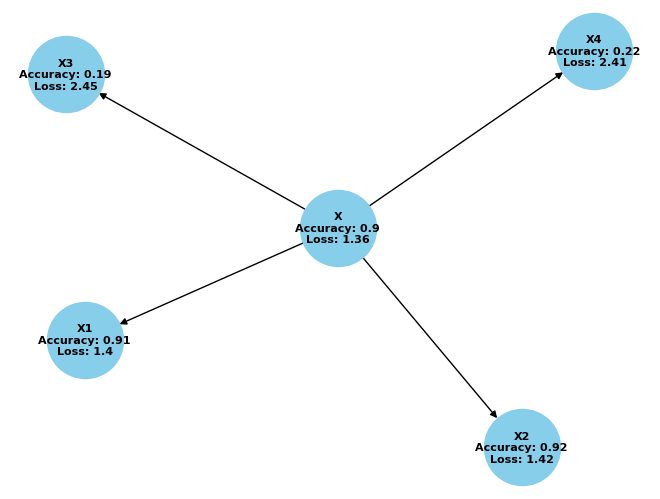

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def add_nodes_and_edges(graph, parent_node):
    decimal_points = 2
    parent_state = parent_node["State"]
    for child in parent_node["Next States"]:
        child_state = child["State"]
        # Create a label with selected information
        label = f"{child_state}\nAccuracy: {round(child['Accuracy'], decimal_points)}\nLoss: {round(child['Loss'], decimal_points)}"
        graph.add_node(child_state, label=label)
        graph.add_edge(parent_state, child_state)
        add_nodes_and_edges(graph, child)

def plot_tree(tree):
    decimal_points = 2
    G = nx.DiGraph()

    # Add the root node
    root_state = tree["State"]
    root_label = f"{root_state}\nAccuracy: {round(tree['Accuracy'], decimal_points)}\nLoss: {round(tree['Loss'], decimal_points)}"
    G.add_node(root_state, label=root_label)

    # Add children recursively
    add_nodes_and_edges(G, tree)

    # Draw the graph
    pos = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    nx.draw(G, pos, labels=labels, with_labels=True, node_color="skyblue", node_size=3000, font_size=8, font_weight="bold", arrows=True)
    plt.show()
    
plot_tree(root)